[*********************100%***********************]  1 of 1 completed

Epoch 1/100


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0188
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.7255e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.4500e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.5275e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.2735e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.9893e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.9940e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.3219e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.1510e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.7861e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.6577e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.2672e-04
Epoch 15/100
17/17 ━━━━━━

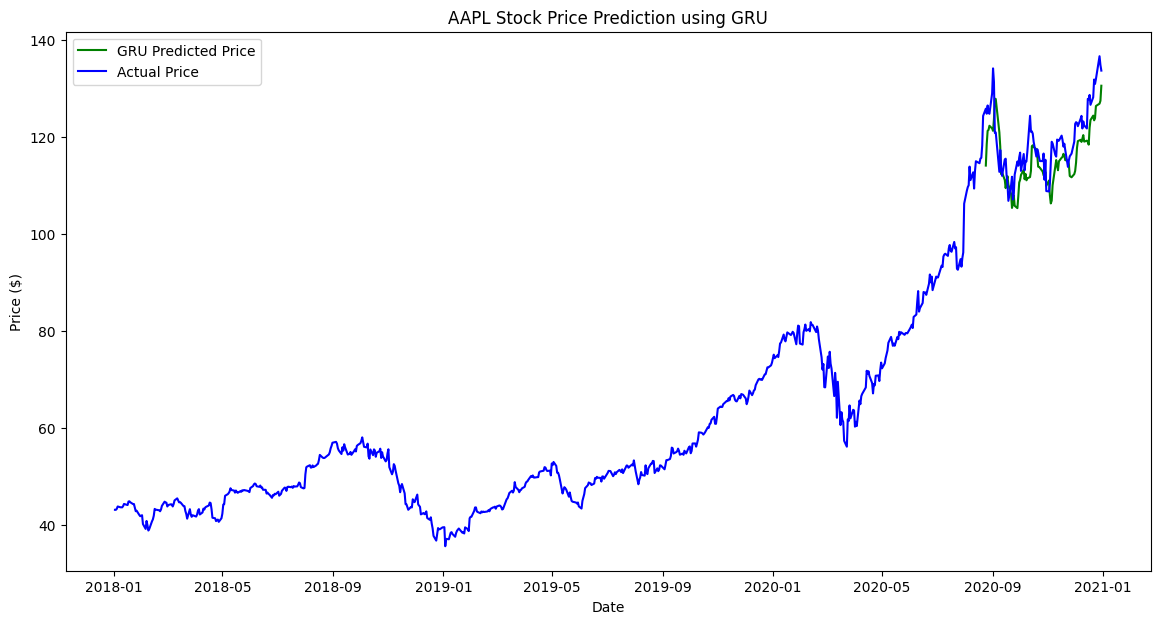

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # train_test_split 임포트
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input  # Input 레이어 임포트

# 1. 데이터 수집
start = '2018-01-01'  # 데이터 시작 날짜
end = '2020-12-31'    # 데이터 종료 날짜
ticker = 'AAPL'       # 주식 티커
df = yf.download(ticker, start=start, end=end)  # yfinance를 사용하여 데이터 다운로드

# 2. 데이터 전처리
data = df['Close'].values.reshape(-1, 1)  # 종가를 2D 배열로 변형
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)  # 데이터 정규화 수행

# 데이터셋 분할: 훈련 데이터와 테스트 데이터
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)  # 20% 테스트 데이터

# GRU 입력 형식에 맞게 데이터 변형
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # 입력 데이터
        y.append(data[i + time_step, 0])      # 타겟 데이터
    return np.array(X), np.array(y)

# 시간 단계 설정
time_step = 60  # 60일의 데이터를 사용하여 예측
X_train, y_train = create_dataset(train_data, time_step)  # 훈련 데이터 생성
X_test, y_test = create_dataset(test_data, time_step)      # 테스트 데이터 생성

# GRU 입력 형태로 변형 (3D 배열)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, time steps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3. GRU 모델 구축
gru_model = Sequential()  # Sequential 모델 초기화
gru_model.add(Input(shape=(X_train.shape[1], 1)))  # Input 레이어 추가
gru_model.add(GRU(units=50, return_sequences=True))  # 첫 번째 GRU 레이어
gru_model.add(Dropout(0.2))  # 과적합 방지를 위한 Dropout
gru_model.add(GRU(units=50, return_sequences=False))  # 두 번째 GRU 레이어
gru_model.add(Dropout(0.2))  # 과적합 방지를 위한 Dropout
gru_model.add(Dense(units=1))  # 최종 출력 레이어
gru_model.compile(optimizer='adam', loss='mean_squared_error')  # 모델 컴파일
gru_model.fit(X_train, y_train, epochs=100, batch_size=32)  # 모델 훈련

# 4. 예측 수행
gru_predicted_prices = gru_model.predict(X_test)    # GRU 예측

# 예측 결과를 원래 스케일로 변환
gru_predicted_prices = scaler.inverse_transform(gru_predicted_prices)

# 5. 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index[len(train_data) + time_step + 1:], gru_predicted_prices, color='green', label='GRU Predicted Price')  # GRU 예측 결과
plt.plot(df.index, data, color='blue', label='Actual Price')  # 실제 가격
plt.title(f'{ticker} Stock Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()